In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
#sys.path.append(os.path.join(os.getcwd(), '..'))
from einops import rearrange
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from ldm.util import instantiate_from_config


from copy import deepcopy
import argparse, os, sys, glob
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from pathlib import Path


from skimage.metrics import structural_similarity as ssim
from ldm.data.deepfashion_inshop import DeepFashionSample
from ldm.data.segm_utils import LipSegmenter

import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle
import random

from ldm.data.generate_utils import InferenceModel, draw_styles, convert_fname, interp_mask

## Load Model

In [3]:
device = 'cuda:0'

# low res
CONFIG = 'models/upgpt/pt_256/config.yaml'
CKPT = 'models/upgpt/pt_256/upgpt.pt256.v1.ckpt'

#high res
CONFIG = 'models/upgpt/mm_512/config.yaml'
CKPT = 'models/upgpt/mm_512/upgpt.mm512.v1.ckpt'

# interpolation
CONFIG = 'models/upgpt/interp_256/config.yaml'
CKPT = 'models/upgpt/interp_256/upgpt.interp256.v1.ckpt'

# load config and model
config = OmegaConf.load(CONFIG)
crop_size = config['model']['params']['crop_size']    
model = InferenceModel(config, CKPT, device)


Loading model from models/upgpt/interp_256/upgpt.interp256.v1.ckpt
Global Step: 24952
LatentDiffusion: Running in eps-prediction mode


/home/soon/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(


DiffusionWrapper has 425.29 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.layer_norm1.bias', 'vision_model.encoder.layers.21.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.16.layer_norm2.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.layer_norm1.bias', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encod

## Load data

In [4]:
ds = DeepFashionSample(**config['data']['params']['test']['params'])

In [5]:
men = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='MEN' and  'full' in x]
women = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='WOM' and 'full' in x and 'Dres' in x]
len(women)

857

In [5]:
'''
result_root = 'logs/2023-02-03T22-46-00_inshop_lip_clip_recon_newname/results'
df = pd.read_csv(os.path.join(result_root, 'metrics_png.csv'))
#df['men'] = df['name'].map(lambda x: x[:10]=='fashionMEN')
#check_df = df[df['men']].sort_values(by=['SSIM'], ascending=False)
check_df = df.sort_values(by=['SSIM'], ascending=False)
'''

"\nresult_root = 'logs/2023-02-03T22-46-00_inshop_lip_clip_recon_newname/results'\ndf = pd.read_csv(os.path.join(result_root, 'metrics_png.csv'))\n#df['men'] = df['name'].map(lambda x: x[:10]=='fashionMEN')\n#check_df = df[df['men']].sort_values(by=['SSIM'], ascending=False)\ncheck_df = df.sort_values(by=['SSIM'], ascending=False)\n"

In [6]:
'''
start_idx = 5
for i in range(start_idx, start_idx+5):
    fname = check_df.iloc[i]['name']
    plt.figure(figsize=(10,10))
    plt.imshow(Image.open(os.path.join(result_root,'concats',fname)))
    plt.show()
    print(i)
'''

"\nstart_idx = 5\nfor i in range(start_idx, start_idx+5):\n    fname = check_df.iloc[i]['name']\n    plt.figure(figsize=(10,10))\n    plt.imshow(Image.open(os.path.join(result_root,'concats',fname)))\n    plt.show()\n    print(i)\n"

In [7]:
'''
select_id = 34
name_string = check_df.iloc[select_id]['name']
convert_fname(name_string.split('.')[0])
'''

"\nselect_id = 34\nname_string = check_df.iloc[select_id]['name']\nconvert_fname(name_string.split('.')[0])\n"

In [6]:
style_id = convert_fname('fashionWOMENShortsid0000478403_4full')[0]+'.jpg'
style_batch = ds[style_id]

style2_id = convert_fname('fashionWOMENSkirtsid0000698402_1front')[0]+'.jpg'
style2_batch = ds[style2_id]

WOMEN/Dresses/id_00006168/08_4_full WOMEN/Dresses/id_00002177/02_4_full
The person wears a sleeveless tank shirt with color block patterns and a three-point pants. The tank shirt is with cotton fabric. The neckline of the tank shirt is round. The pants are with cotton fabric and pure color patterns. There is an accessory on her wrist. The female is wearing leggings. This female is wearing a ring on her finger. This woman is wearing a hat.
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (8, 4, 32, 24), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|████████████████████████████| 200/200 [00:10<00:00, 18.72it/s]


Plotting: Restored training weights


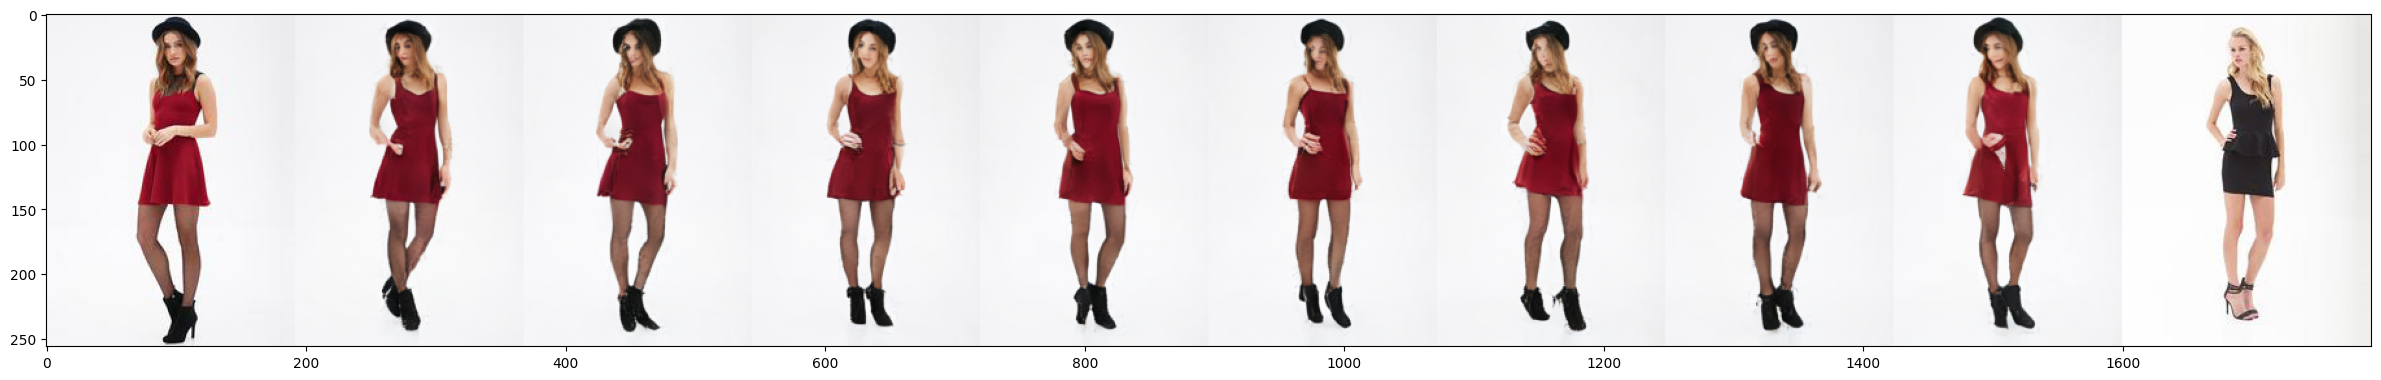

In [9]:
src_id = 'WOMEN/Dresses/id_00006168/08_4_full'
#dst_id = 'MEN/Tees_Tanks/id_00007466/08_2_side'
#dst_id = random.choice(men)
dst_id = random.choice(women)
#src_id = random.choice(women)
#dst_id = 'WOMEN-Dresses-id_00006868-02_4_full'.replace('-','/')
#dst_id = 'WOMEN-Jackets_Coats-id_00007450-02_1_front'.replace('-','/')
#dst_id = src_id
#name_string ='fashionWOMENJackets_Coatsid0000056302_4full___fashionWOMENJackets_Coatsid0000056302_4full'
#src_id, dst_id  = convert_fname(name_string.split('.')[0])
pose_interp = []


src_batch = ds[src_id+'.jpg']
dst_batch = ds[dst_id+'.jpg']

src_image = np.uint8(((src_batch['image']+1)/2)*255)
dst_image = np.uint8(((dst_batch['image']+1)/2)*255)
src_smpl_image = Image.fromarray(np.uint8(((src_batch['smpl_image']+1)/2)*255))
dst_smpl_image = Image.fromarray(np.uint8(((dst_batch['smpl_image']+1)/2)*255))
print(src_id, dst_id)
#dst_batch['txt'] = src_batch['txt']
#src_batch['styles'] = dst_batch['styles']

text_style = {#'face': "European white male",
              #'hair':'short hair',
              #'headwear': 'a red hat',
              #'background':'brown flooring',
              #'top':'a green short sleeve shirt in plaid pattern',
              #'outer':'long sleeved jacket in orange leopard pattern',
              #'bottom':'red dress in stripe pattern',
              #'shoes':'black shoes',
              #'accesories':''
                }

style_mask = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
style_mask = []
'''
for transfer_id in [0,1]:
    src_batch['styles'][transfer_id] = style_batch['styles'][transfer_id]

for transfer_id in [6]:
    src_batch['styles'][transfer_id] = style2_batch['styles'][transfer_id]
'''    
src_batch['styles'] = model.mix_style(src_batch['styles'], text_style, mask=style_mask)

#dst_batch['smpl'][0,72:82] = src_batch['smpl'][0,72:82]
src_batch['smpl'] = dst_batch['smpl']
src_batch['person_mask'] = dst_batch['person_mask']

#src_batch['person_mask'] = dst_batch['person_mask']
print(src_batch['txt'])
#dst_batch['styles'] = clip_image_encoder(dst_batch['styles'].unsqueeze(0).to(device)).squeeze()
#src_batch['txt'] = 'er T-shirt has short sleeves, cotton fabric and pure color patterns. The neckline of it is lapel. The trousers this lady wears is of long length. The trousers are with denim fabric and pure color patterns. The person also wears an outer clothing, with denim fabric and solid color patterns. There is a ring on her finger. There is an accessory on her wrist.'

alphas = np.arange(1.0,0.5,-0.05)
#alphas = np.array([1, 1, 1, 1, 1, 1, 1, 1])
repeat = len(alphas)
src_batch = model.create_batch(src_batch, repeat)

#pose interpolation   

for i, alpha in enumerate(alphas):    
    src_batch['smpl'][i] = alpha * src_batch['smpl'][i] + (1 - alpha) * dst_batch['smpl'].to(device)
    src_batch['person_mask'][i] = interp_mask(src_batch['person_mask'][i], dst_batch['person_mask'], alpha)
        
    
log = model.generate(src_batch, 200)
samples = [np.array(T.CenterCrop(crop_size)(Image.fromarray(np.uint8(x*255)))) for x in log['samples']]
plt.figure(figsize=(30,30))
plt.imshow(np.hstack((src_image, np.hstack(samples), dst_image)))
#sample = T.CenterCrop(size=(2*256, 2*176))(Image.fromarray(np.uint8(log['samples'][0]*255)))
#sample.save(os.path.join(folder, j))
#plt.figure(figsize=(10,10))
#concat = np.hstack((src_image, np.array(sample), dst_image))
#pose_interp.append(np.array(sample))
#plt.imshow(concat)
#plt.axis('off')
#plt.show()

#concat = np.hstack((src_image, np.hstack(pose_interp), dst_image))
#plt.figure(figsize=(10,10))
#plt.imshow(concat)
#plt.axis('off')
#plt.show()


In [ ]:
folder = './figures/512/'+src_id.replace('/','-')+'_female'
os.makedirs(folder,exist_ok=True)
smpl_image = src_batch['smpl_image'][0].cpu().numpy()*0.5+0.5
smpl_image = Image.fromarray((smpl_image*255).astype(np.uint8))
smpl_image = T.CenterCrop((512,256))(smpl_image.resize((192*2,256*2)))
smpl_image.save(os.path.join(folder,f'smpl.jpg'))
with open(os.path.join(folder, 'caption.txt'), 'w') as f:
    f.write(src_batch['txt'][0])


offset = 0
for i, sample in enumerate(samples):
    path = os.path.join(folder,f'{i+offset}.jpg')
    #assert not os.path.isfile(path)
    Image.fromarray(sample).save(path)


In [ ]:
plt.figure(figsize=(30,30))  
plt.imshow(np.hstack((src_image, np.hstack(samples))))

In [ ]:
folder = "./figures/512/"
os.makedirs(folder,exist_ok=True)
path = os.path.join(folder,name_string)
#assert not os.path.isfile(path)
Image.fromarray(pose_interp[0]).save(path)

In [ ]:
folder = "./figures/interp/1/"
os.makedirs(folder, exist_ok=True)
src_name = os.path.join(folder, src_id.replace('/','-')+'.png')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.png')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

In [ ]:
#for i in range(len(pose_interp)):
#    Image.fromarray(pose_interp[i]).save(os.path.join(folder,f'{i}.jpg'))

In [ ]:
folder = "./figures/interp/0/"
os.makedirs(folder,exist_ok=True)
name = 'panda'
path = os.path.join(folder, name+'.png')
assert not os.path.isfile(path)
sample.save(path)

In [ ]:
src_smpl_image = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(((src_batch['smpl_image'][0].cpu().numpy()+1)/2)*255)))
src_smpl_image

In [ ]:
src_name = os.path.join(folder, src_id.replace('/','-')+'.png')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.png')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

src_smpl_image.save(os.path.join(folder,'src_smpl.png'))

In [ ]:
draw_styles(dst_batch['styles'])